In [2]:
import re
import string 
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/spam.csv


In [5]:
data = pd.read_csv('data/spam.csv', 
                   encoding = 'latin-1')
data.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [6]:
cols = data.columns[2:5]
data = data.drop(cols, axis = 1)
data.columns = ['y', 'text']
data.head(3)

,y,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


Text(0.5, 1.0, 'count')

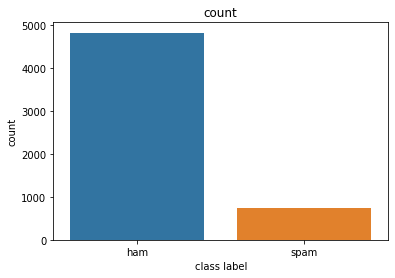

In [7]:
sns.countplot(x = data.y)
plt.xlabel('class label')
plt.title('count')

In [8]:
le = LabelEncoder()
data['label'] = le.fit_transform(data.y)
data.head(3)

,y,text,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1


In [9]:
X = data.loc[:, ['text']]
y = data.loc[:, ['label']]
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    stratify = y,
                                                    test_size=0.3,
                                                    random_state=42)

We will first build a naive bayes classifier since it had been a milestone for spam massage filters. We start with utility functions

In [10]:
stemmer = PorterStemmer()
stop_words = stopwords.words('english')

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def stem_text(text):
    return ' '.join([stemmer.stem(t) for t in text.split()])

def remove_stop_words(text):
    return ' '.join([t for t in text.split() if t not in stop_words])

def df_clean_text(df):
    return df['text'].apply(clean_text).to_frame()

def df_stem_text(df):
    return df['text'].apply(stem_text).to_frame()
    
def df_remove_stop_words(df):
    return df['text'].apply(remove_stop_words)

class DataframeFunctionTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

Now we must create vector representation of these messages in order to train our model.

In [11]:
tfidf_transformer = TfidfTransformer()
smote = SMOTE(random_state=42)

In [12]:
nb_clf = Pipeline([
    ("clean", DataframeFunctionTransformer(df_clean_text)),
    ("stem", DataframeFunctionTransformer(df_stem_text)),
    ("rm_stop", DataframeFunctionTransformer(df_remove_stop_words)),
    ('vect', CountVectorizer(stop_words='english',
                             ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('smote', smote),
    ('clf', MultinomialNB())])

In [13]:
nb_clf.fit(X_train, y_train.squeeze())

Pipeline(steps=[('clean',
                 <__main__.DataframeFunctionTransformer object at 0x125a4d940>),
                ('stem',
                 <__main__.DataframeFunctionTransformer object at 0x125a4d220>),
                ('rm_stop',
                 <__main__.DataframeFunctionTransformer object at 0x125a4d1f0>),
                ('vect',
                 CountVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('smote', SMOTE(random_state=42)), ('clf', MultinomialNB())])

In [14]:
y_pred = nb_clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1448
           1       0.75      0.93      0.83       224

    accuracy                           0.95      1672
   macro avg       0.87      0.94      0.90      1672
weighted avg       0.96      0.95      0.95      1672



In [15]:
# pickle our model for deployment
import pickle
with open("classifier.pkl", "wb") as classifier_pkl:
    pickle.dump(nb_clf, classifier_pkl)